# Mushroom Stew Classification

<img src="https://www.umami-insider.com/asset/uploads/different-mushrooms.jpg" width=600 height=300 />

-----------

In [5]:
# Data Management
import numpy as np
import pandas as pd
from prettytable import PrettyTable
from random import shuffle, sample

# Data Visualization
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
import sweetviz as sv
from pandas_profiling import ProfileReport
from plotnine import ggplot, aes, geom_jitter, scale_color_manual, theme, labs, theme_bw
from yellowbrick.classifier import ClassificationReport, ConfusionMatrix, ROCAUC, PrecisionRecallCurve, ClassPredictionError, DiscriminationThreshold
from yellowbrick.model_selection import FeatureImportances, LearningCurve, ValidationCurve
from yellowbrick.target import ClassBalance

# Modeling & Metrics
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectKBest, chi2, mutual_info_classif
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, precision_score, recall_score, f1_score, plot_roc_curve, RocCurveDisplay, plot_confusion_matrix, ConfusionMatrixDisplay, roc_auc_score, roc_curve
from sklearn.model_selection import cross_val_score, cross_val_predict, GridSearchCV, learning_curve
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler, RobustScaler, minmax_scale, LabelEncoder
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier, export_text, plot_tree

# Utils
import ipywidgets as widgets
from ipywidgets import interact, interact_manual
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline
plt.style.use('default')  # 'dark_background'

## Data loading
---------

#### Retrieve dataset from *UCI*:

The data can be downloaded at the following url: https://archive.ics.uci.edu/ml/machine-learning-databases/mushroom/expanded.Z 
<br>
The decompressed data file should be saved within the same directory as the notebook for execution.

In [6]:
# Compile dataset attribute names based on source metadata
attr = [
    'label', 'cap_shape', 'cap_surface', 'cap_color', 'bruises', 'odor',  
    'gill_attachment', 'gill_spacing', 'gill_size', 'gill_color', 'stalk_shape', 'stalk_root', 
    'stalk_surface_above_ring', 'stalk_surface_below_ring', 'stalk_color_above_ring', 'stalk_color_below_ring', 
    'veil_type', 'veil_color', 'ring_number', 'ring_type', 'spore_print_color', 'population', 'habitat'
]

# Load dataset from downloaded & decompressed datafile (skipping initial and end lines)
mushroom_df = pd.read_csv('expanded.csv', sep=',', index_col=None, header=None, names=attr, skiprows=9, skipfooter=1) 

mushroom_df

label cap_shape cap_surface cap_color  bruises    odor gill_attachment  \
0     EDIBLE    CONVEX      SMOOTH     WHITE  BRUISES  ALMOND            FREE   
1     EDIBLE    CONVEX      SMOOTH     WHITE  BRUISES  ALMOND            FREE   
2     EDIBLE    CONVEX      SMOOTH     WHITE  BRUISES  ALMOND            FREE   
3     EDIBLE    CONVEX      SMOOTH     WHITE  BRUISES  ALMOND            FREE   
4     EDIBLE    CONVEX      SMOOTH     WHITE  BRUISES  ALMOND            FREE   
...      ...       ...         ...       ...      ...     ...             ...   
8411  EDIBLE   KNOBBED      SMOOTH     BROWN       NO    NONE        ATTACHED   
8412  EDIBLE   KNOBBED      SMOOTH     BROWN       NO    NONE        ATTACHED   
8413  EDIBLE   KNOBBED      SMOOTH     BROWN       NO    NONE        ATTACHED   
8414  EDIBLE   KNOBBED      SMOOTH     BROWN       NO    NONE        ATTACHED   
8415  EDIBLE   KNOBBED      SMOOTH     BROWN       NO    NONE        ATTACHED   

     gill_spacing gill_size gill_color  ... stalk_surface_below_ring  \
0         CROWDED    NARROW      WHITE  ...                   SMOOTH   
1         CROWDED    NARROW      WHITE  ...                   SMOOTH   
2         CROWDED    NARROW       PINK  ...                   SMOOTH   
3         CROWDED    NARROW       PINK  ...                   SMOOTH   
4         CROWDED    NARROW      BROWN  ...                   SMOOTH   
...           ...       ...        ...  ...                      ...   
8411        CLOSE     BROAD      BROWN  ...                   SMOOTH   
8412        CLOSE     BROAD      BROWN  ...                   SMOOTH   
8413        CLOSE     BROAD      BROWN  ...                   SMOOTH   
8414        CLOSE     BROAD      BROWN  ...                   SMOOTH   
8415        CLOSE     BROAD      BROWN  ...                   SMOOTH   

     stalk_color_above_ring stalk_color_below_ring veil_type veil_color  \
0                     WHITE                  WHITE   PARTIAL      WHITE   
1                     WHITE                  WHITE   PARTIAL      WHITE   
2                     WHITE                  WHITE   PARTIAL      WHITE   
3                     WHITE                  WHITE   PARTIAL      WHITE   
4                     WHITE                  WHITE   PARTIAL      WHITE   
...                     ...                    ...       ...        ...   
8411                 ORANGE                 ORANGE   PARTIAL      BROWN   
8412                 ORANGE                 ORANGE   PARTIAL      BROWN   
8413                 ORANGE                 ORANGE   PARTIAL      BROWN   
8414                 ORANGE                 ORANGE   PARTIAL      BROWN   
8415                 ORANGE                 ORANGE   PARTIAL      BROWN   

     ring_number ring_type spore_print_color population habitat  
0            ONE   PENDANT            PURPLE    SEVERAL   WOODS  
1            ONE   PENDANT             BROWN    SEVERAL   WOODS  
2            ONE   PENDANT            PURPLE    SEVERAL   WOODS  
3            ONE   PENDANT             BROWN    SEVERAL   WOODS  
4            ONE   PENDANT            PURPLE    SEVERAL   WOODS  
...          ...       ...               ...        ...     ...  
8411         ONE   PENDANT             BROWN  CLUSTERED  LEAVES  
8412         ONE   PENDANT            ORANGE    SEVERAL  LEAVES  
8413         ONE   PENDANT            ORANGE  CLUSTERED  LEAVES  
8414         ONE   PENDANT              BUFF    SEVERAL  LEAVES  
8415         ONE   PENDANT              BUFF  CLUSTERED  LEAVES  

[8416 rows x 23 columns]

## Exploratory Data Analysis
-------

#### Generate exploratory reports through `Pandas Profiling` & `Sweetviz`:

In [7]:
mushroom_profile = ProfileReport(mushroom_df, explorative=True, title="Mushroom Profile", progress_bar=False, pool_size=0)
mushroom_profile.to_notebook_iframe()
mushroom_profile

                                             |                          | [  0%]   00:00 -> (? left)


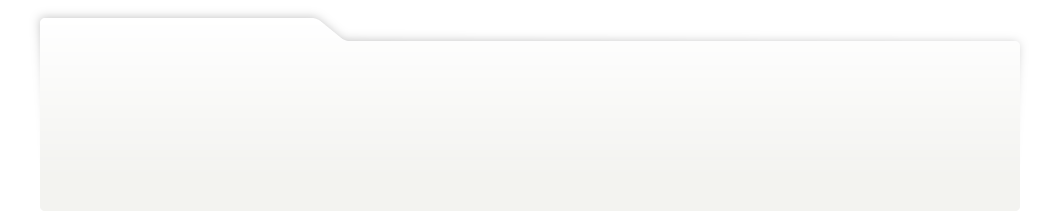
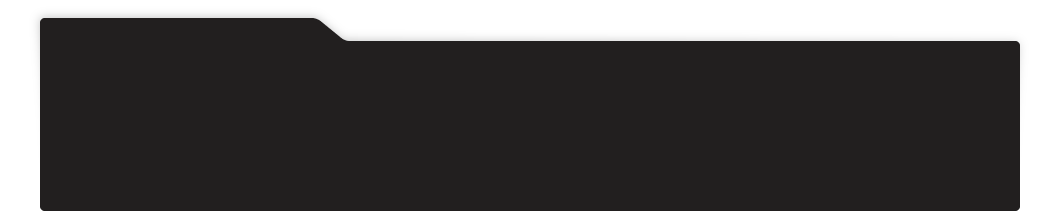
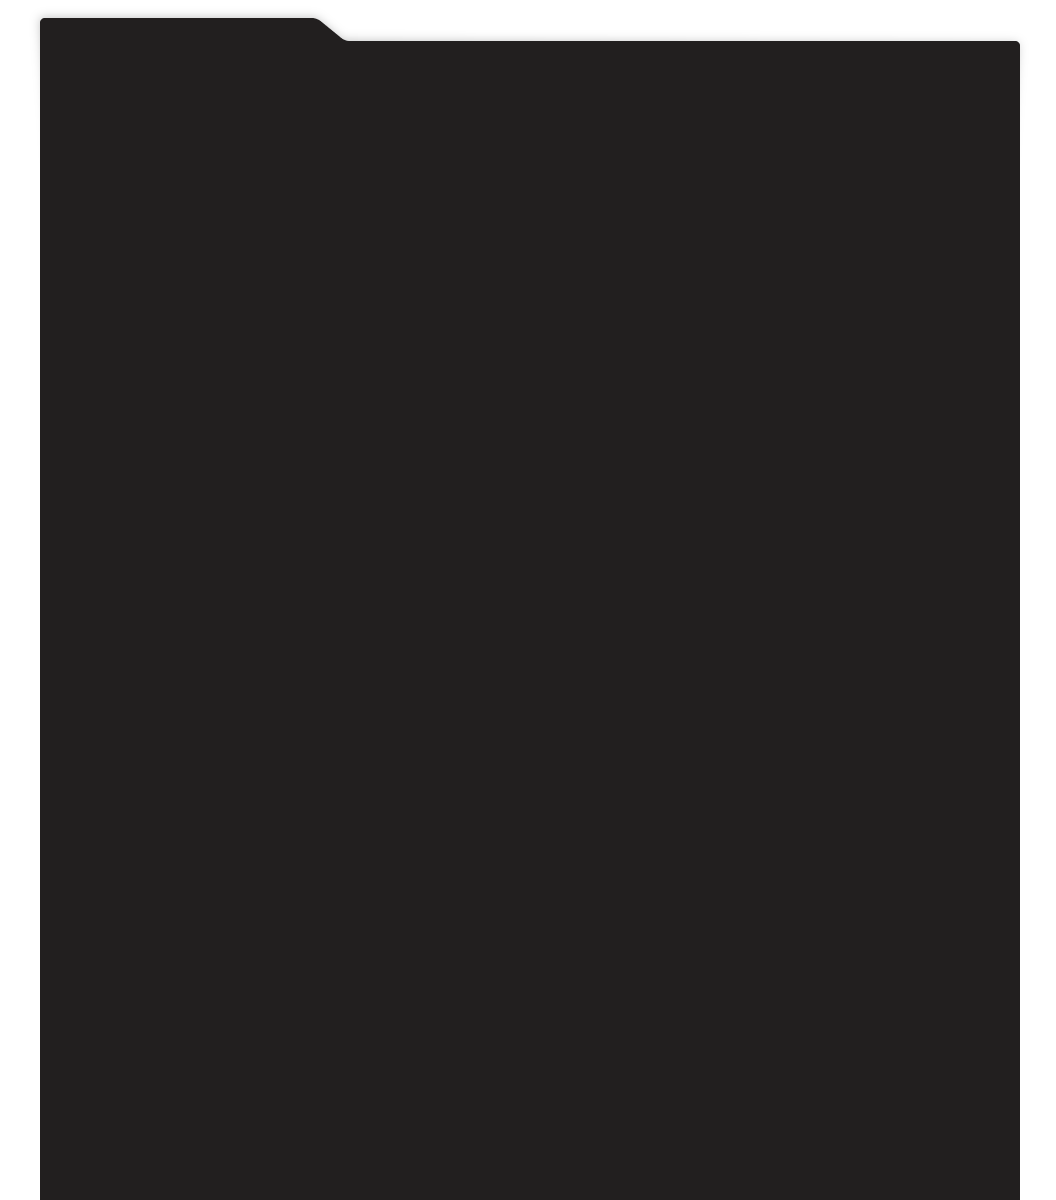
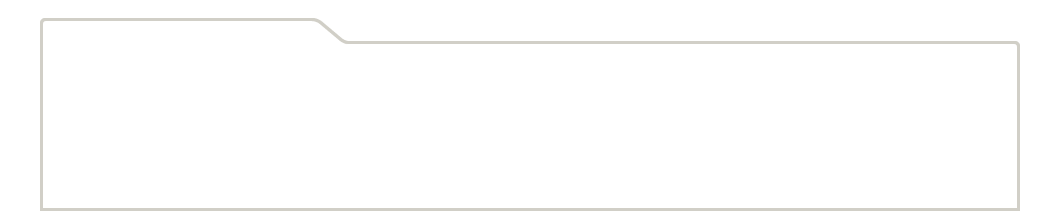
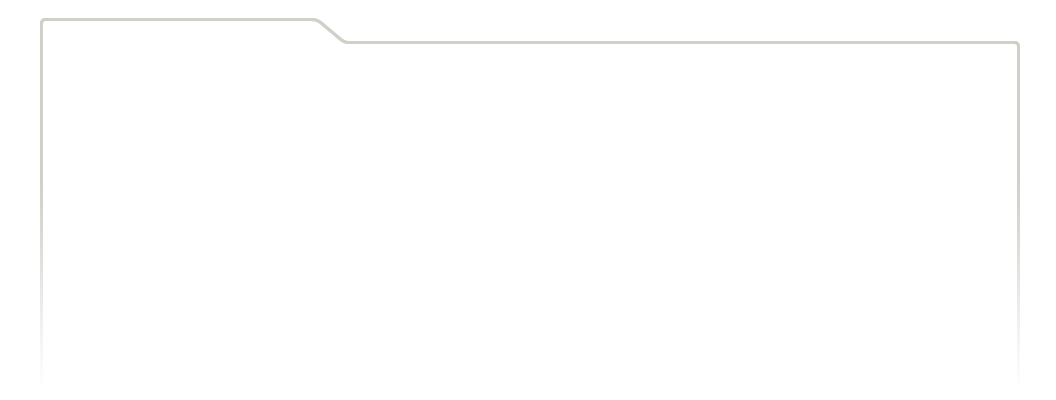
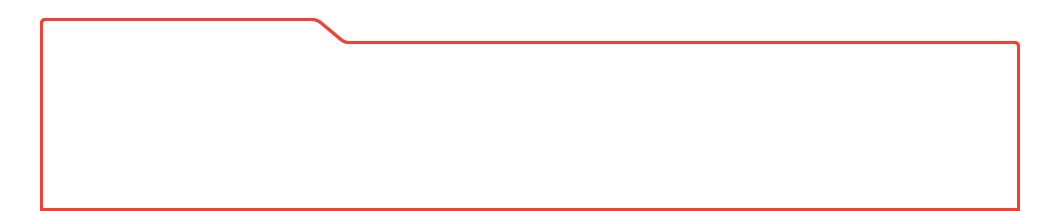
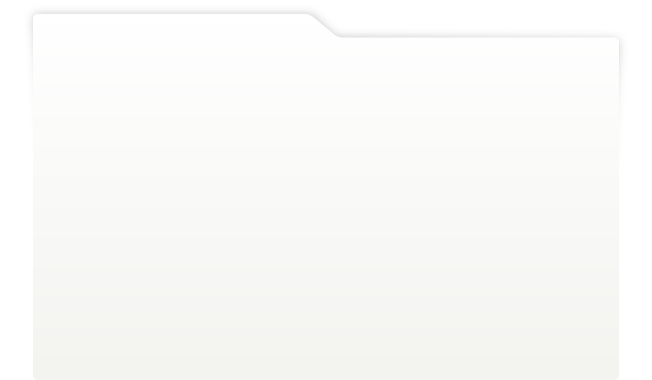
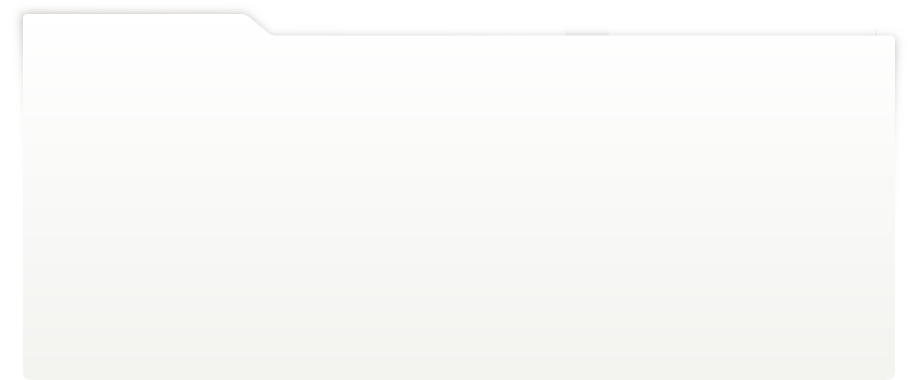
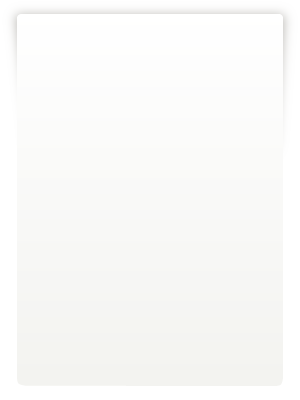
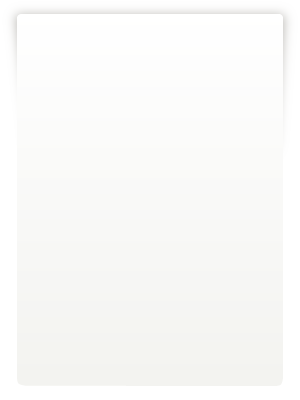
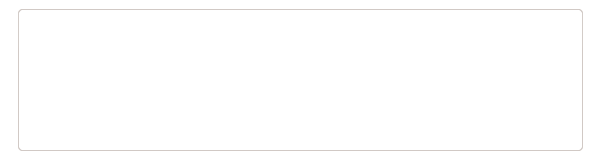
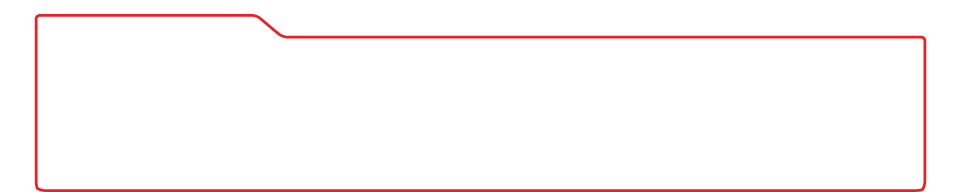
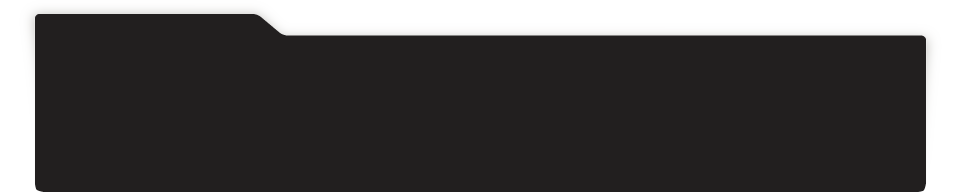
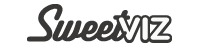
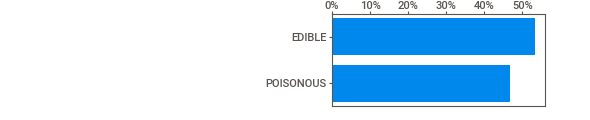
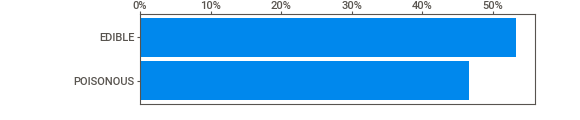
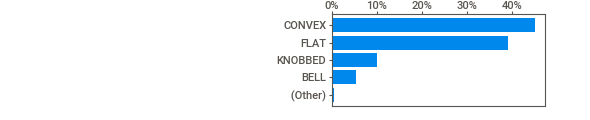
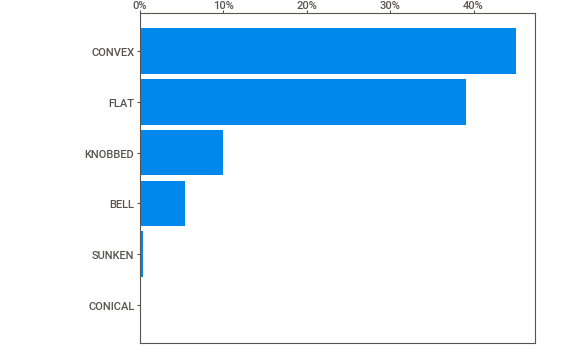
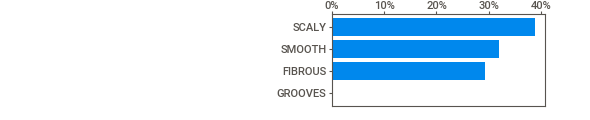
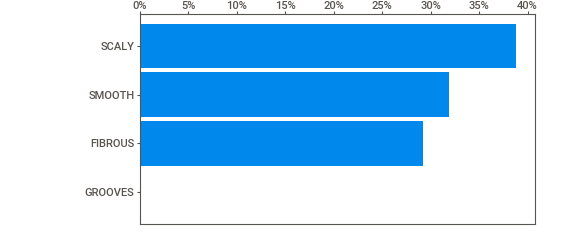
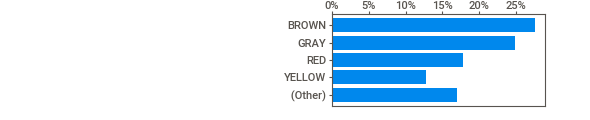
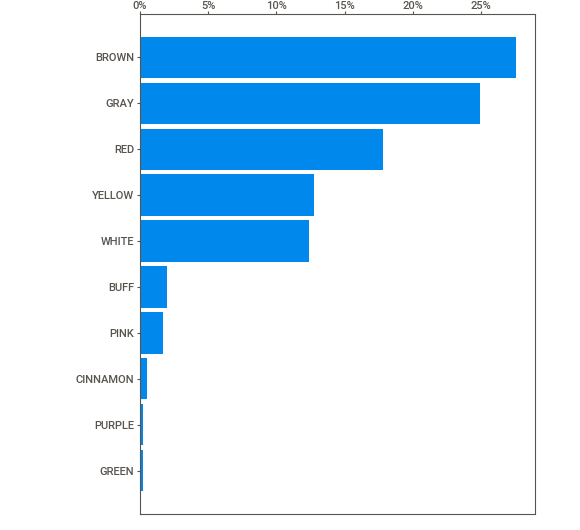
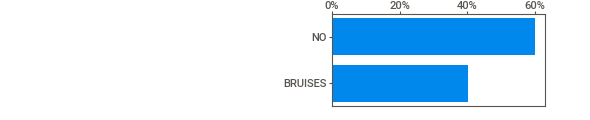
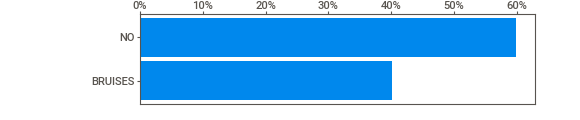
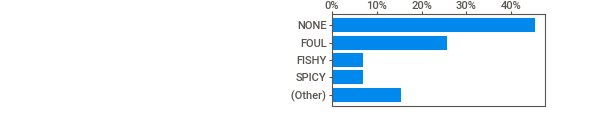
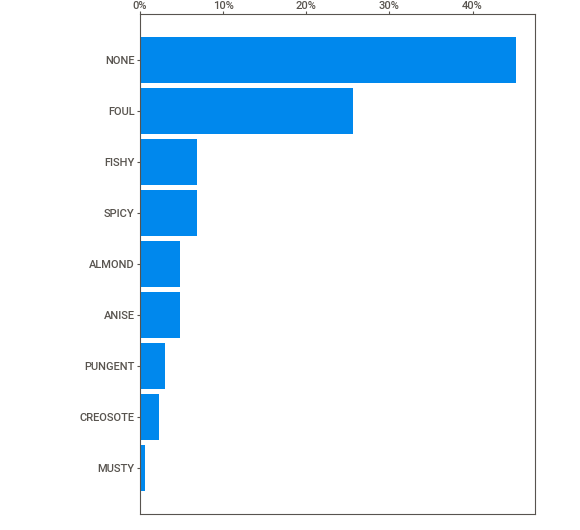
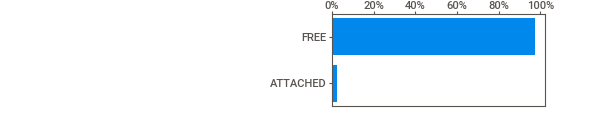
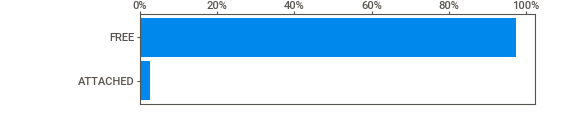
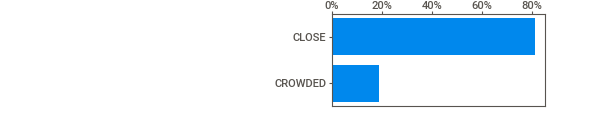
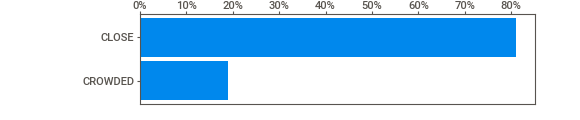
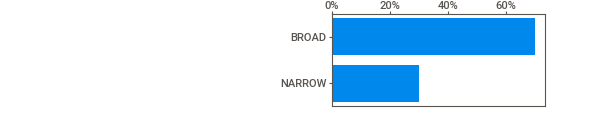
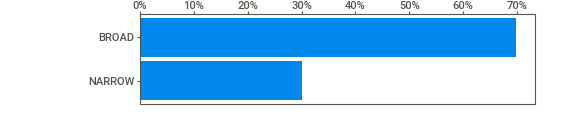
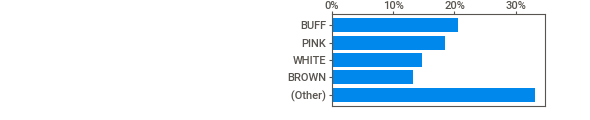
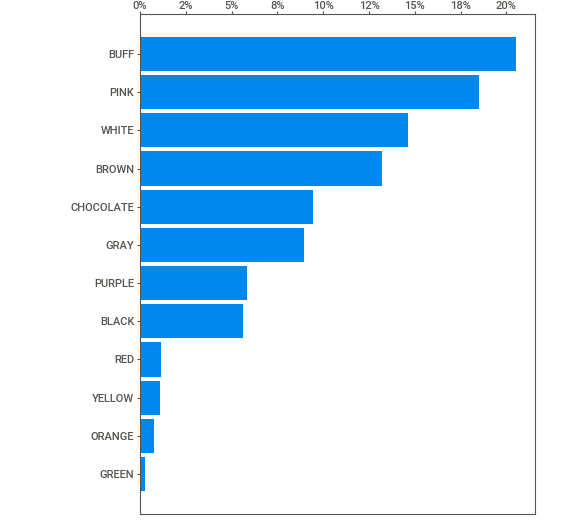
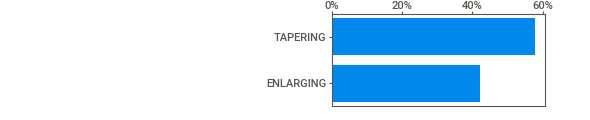
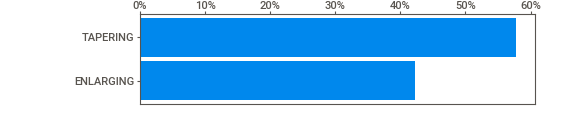
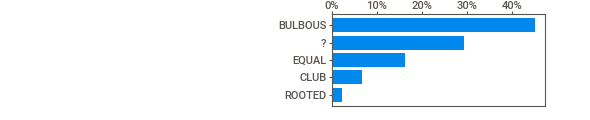
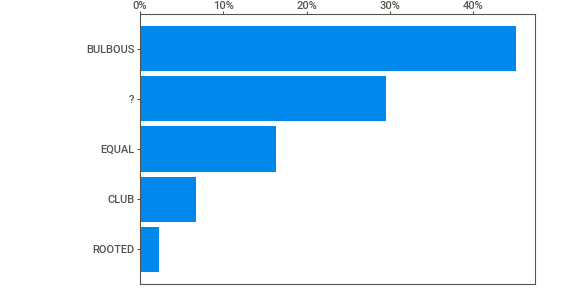
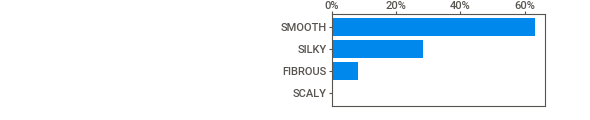
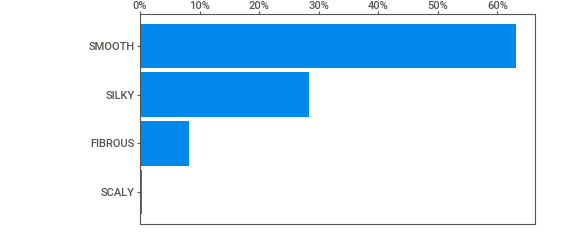
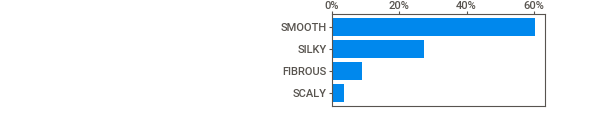
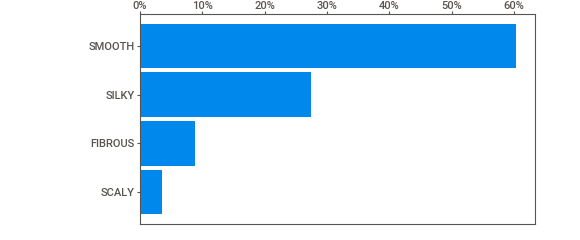
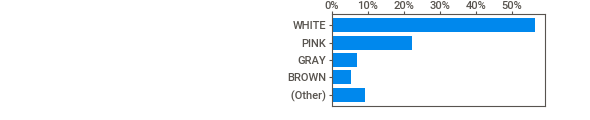
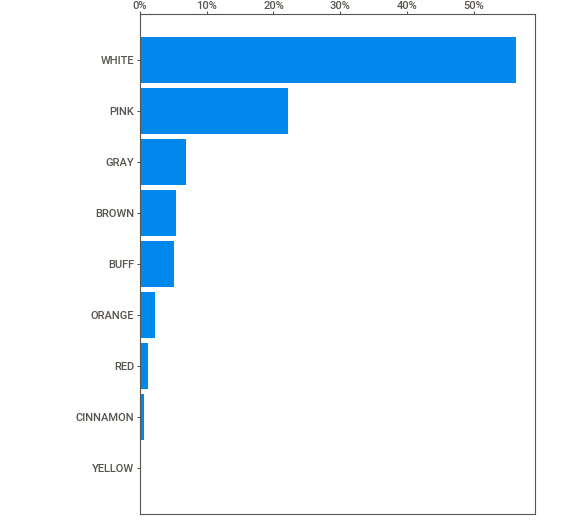
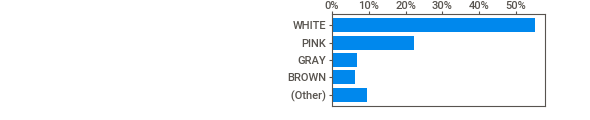
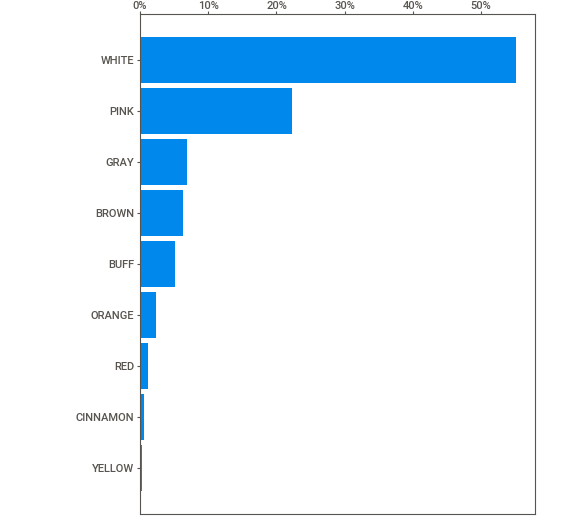
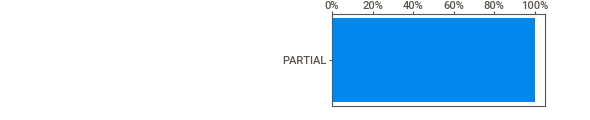
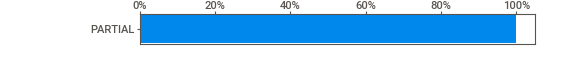
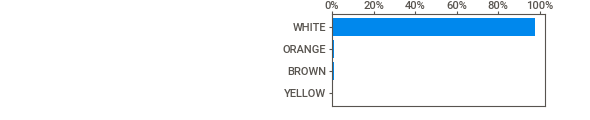
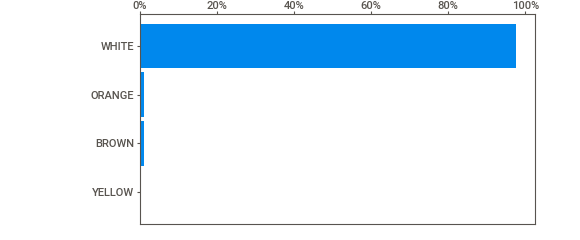
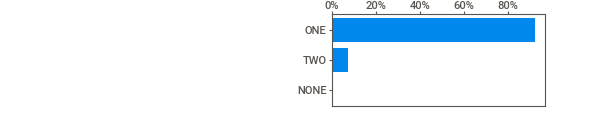
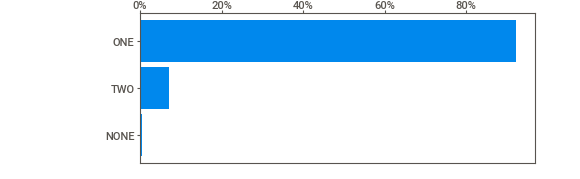
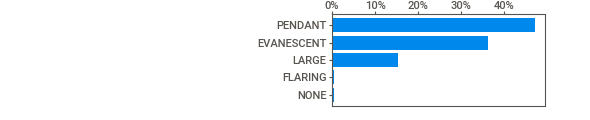
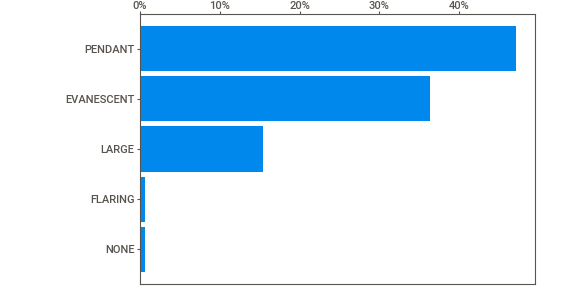
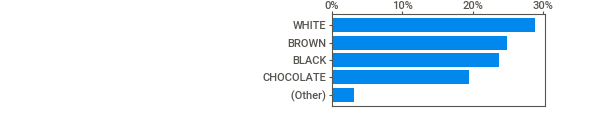
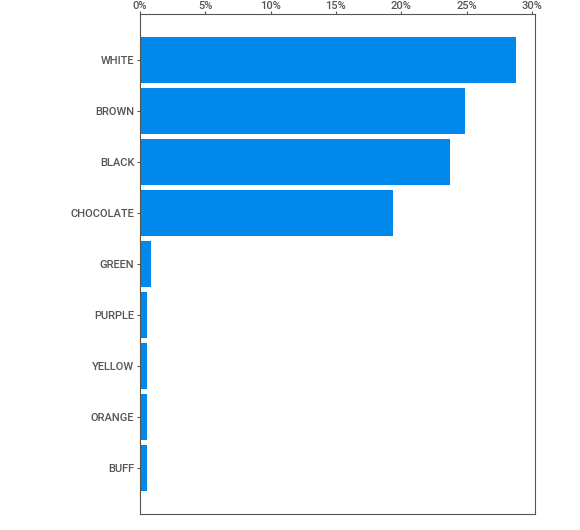
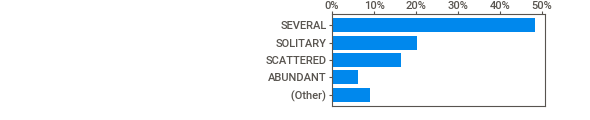
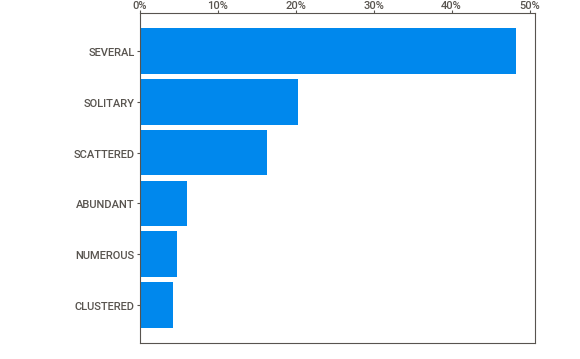
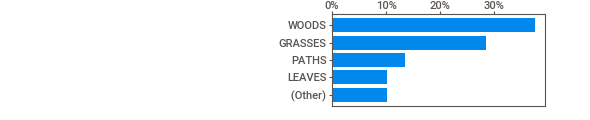
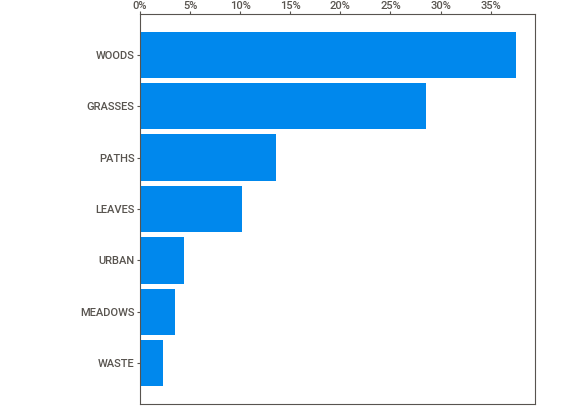
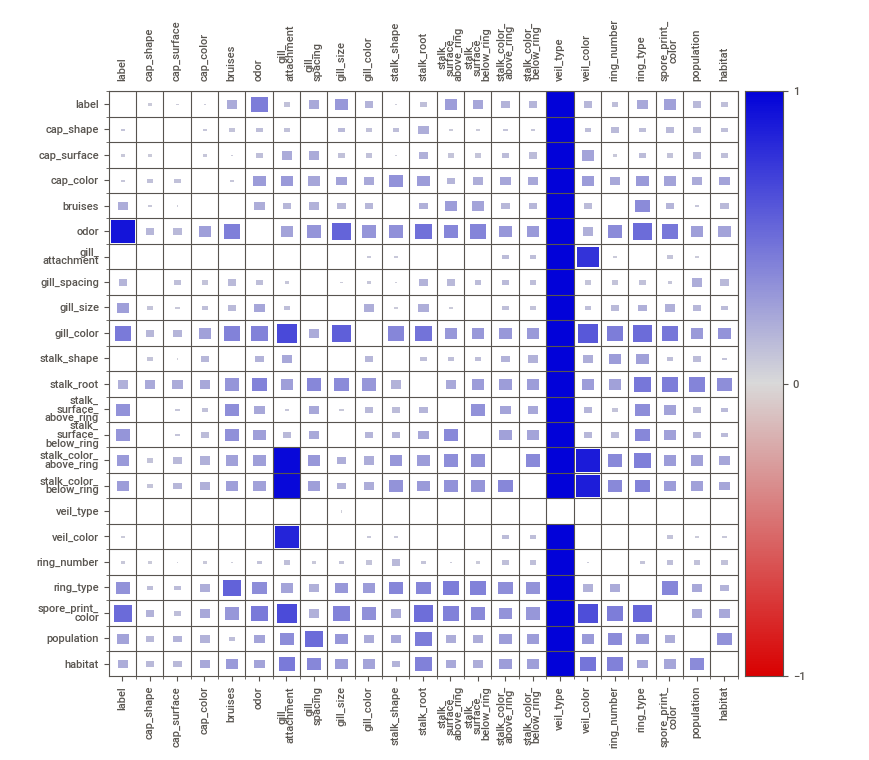
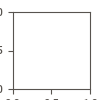

In [8]:
sv_report = sv.analyze(mushroom_df)
sv_report.show_notebook(w='100%', h=400)

From the above profiles, we can draw the following observations:

- Each feature is a categorical variable
- No missing values, but there are duplicate records that should be removed prior to modeling
- Features that exhibit high correlation with target:
    - `odor` -- potentially an important feature for classification models
- Highly correlated features that may potentially factor into feature selection when constructing models:
    - `stalk_color_above_ring` & `gill_attachment` 
    - `stalk_color_below_ring` & `gill_attachment` 
    - `veil_color` & `gill_attachment` 
- There is a fairly even ratio of classes for target variable (4488 *'EDIBLE'*, 3928 *'POISONOUS'*)
- Features exhibit mostly an uneven ratio of classes:
    - Features with dominating class(es): `gill_attachment` (binary 8k vs. 216), `veil_color`, `ring_number`, `ring_type`
    - `veil_type` has only one class

#### Visualize class-breakdown of each attribute in a custom pie chart:

In [9]:
outer_cols = ['gold', 'maroon', 'lightsteelblue', 'darkseagreen', 'olive', 'orchid', 
              'rosybrown', 'lightseagreen', 'sienna', 'darkslateblue', 'gray', 'darkviolet']
inputs = [attr[2], attr[1]] + attr[3:]  # in specific order

@interact
def plot_pie(feature=inputs):
    """Outputs pie chart of class-breakdowns based on target variable."""
    
    # Get counts of each class for outer-circle (features) and inner-circle (label)
    feature_val_counts = mushroom_df[feature].value_counts().sort_index()
    class_labels = feature_val_counts.index.values
    fig_labels = [class_labels[i][0] for i in range(len(class_labels)) if i%2 != 0]
    tgt_counts = mushroom_df.groupby(feature)['label'].value_counts().sort_index()
    
    # Custom specs
    inner_cols = ['#66b3ff', '#ff6666'] * int(len(feature_val_counts) / 2)
    explode_specs_outer = tuple([0.01] * int(len(feature_val_counts)))
    explode_specs_inner = tuple([0.01] * int(len(tgt_counts)))
    
    # Plot outer and inner pie charts
    plt.pie(feature_val_counts.values, colors=outer_cols, explode=explode_specs_outer, labels=class_labels, startangle=90, frame=True)  # colors=sample(outer_cols, len(class_labels))
    plt.pie(tgt_counts.values, colors=inner_cols, explode=explode_specs_inner, radius=0.75, startangle=90)
    fig = plt.gcf()
    fig.gca().add_artist(plt.Circle((0,0), 0.5, color='black', fc='white', linewidth=0))
    plt.axis('equal')
    plt.title(f'red=poisonous, blue=edible')
    plt.legend()
    plt.tight_layout()
    
    return


interactive(children=(Dropdown(description='feature', options=('cap_surface', 'cap_shape', 'cap_color', 'bruis…

Some notable observations from the pie charts generated above:

- mushroom features that exhibit consistent amount of edible vs. poisonous variations within that feature include:
    - `cap_surface`, `cap_shape`, `cap_color`, `bruises`, `gill_attachment`, `gill_spacing`, `gill_size`, 
    `stalk_shape`, `stalk_root`, `stalk_surface_above_ring`, `stalk_surface_below_ring`, `ring_number`, `spore_print_color`, `habitat`
- mushroom features where variations can dictate edible vs. poisonous types include:
    - `odor`: 'foul', 'almond', 'creosote, 'pungent' variations seem to be edible, while the remaining are mostly poisonous or mixed 
    - `gill_color`: 'buff' is a highly prevalent class within this feature and is edible; remaining are mixed
    - `stalk_color_above_ring` & `stalk_color_above_ring`: 'buff' & 'gray' seem to be edible, while 'orange', 'brown', 'cinnamon' are all poisonous
        - both features might contain redundant information for model 
    - `veil_color`: despite low prevalence, 'orange' indicates poisonous & 'brown' indicates edible
    - `ring_type`: 'large' types are all poisonous while 'none' types are edible; remaining classes are mixed
    - `population`: while most classes are mixed, 'numerous' & 'abundant' seem to be homogenous with poisonous & edible respectively

#### Visualize 480+ possible plots of pair-wise feature combinations based on **EDIBLE** vs. **POISONOUS** mushrooms:

In [10]:
features_set1 = sample(attr[1:], 22)  # shuffling list so each plot execution results in random pair
features_set2 = sample(attr[1:], 22)
color_options = ['blue', 'forestgreen', 'darkcyan', 'black']

@interact
def plot_jitter(x_var=features_set1, y_var=features_set2, hue='label', edible_col=color_options):
    """Outputs ggplot figure with custom plot specs and random feature pair."""
    
    # Set figure specifications for each attribute pair
    chart = ggplot(data=mushroom_df, mapping=aes(x=x_var, y=y_var, color=hue))
    points = geom_jitter(alpha = 0.4)  
    labels = labs(x=x_var, y=y_var)
    theme_grammer = theme(figure_size=(8, 6))  
    colors = scale_color_manual(values=[edible_col, 'red'])
    
    fig = chart + points + labels + theme_bw() + theme_grammer + colors
    return fig

interactive(children=(Dropdown(description='x_var', options=('population', 'gill_color', 'habitat', 'veil_colo…

The jitter plots generated above for each possible pair-wise combination of the categorical features can be studied individually, as well as, within the context of each other to better understand the relationships between mushroom attributes in the context of poisonous and edible variations.

- For many feature combinations, the specific class of one attribute seems to impact the availability of mushroom variations across the classes of the second attribute
    - i.e., only 'broad' gill-size mushrooms have 'buff', 'green', and 'orange' colored spore-prints
- A set of classifaction rules can be derived from each feature-pair combination
    - i.e., among broad-gilled mushrooms, black/brown/buff/orange/yellow are all edible spore-print colors; otherwise, chocolate/purple spore print colors are edible

Exploring the relationships between features above seem to potentially point to rule-based classification techniques or tree-based methods as apt models to learn the complex relationship among the categorical variations to distinguish between edible & poisonous mushrooms.

## Data Pre-Processing

---

Approach:

EDA revealed no missing data at first glance, but upon further examination of the classes of each feature, there are '?' values in `stalk_root` that could be removed. Moreover, there was a small percentage of duplicate records that can be removed. Additionally, `veil_type` only consists of one class and can be removed from analysis. 

All the features were categorical data, preventing the need to scale any attributes. However, this requires converting from string-format to numeric form for modeling. This can be achieved through label encoding or dummy vectorization. 

Although the target variable is fairly evenly distributed among the binary classes, most features exhibit skewed ratio of values. This must also be taken into account while modeling. 

In [12]:
for col in mushroom_df.columns:
    print(col)
    print(mushroom_df[col].unique())
    print()

label
['EDIBLE' 'POISONOUS']

cap_shape
['CONVEX' 'FLAT' 'BELL' 'SUNKEN' 'KNOBBED' 'CONICAL']

cap_surface
['SMOOTH' 'FIBROUS' 'SCALY' 'GROOVES']

cap_color
['WHITE' 'YELLOW' 'BROWN' 'GRAY' 'RED' 'PINK' 'PURPLE' 'GREEN' 'BUFF'
 'CINNAMON']

bruises
['BRUISES' 'NO']

odor
['ALMOND' 'ANISE' 'NONE' 'PUNGENT' 'CREOSOTE' 'FOUL' 'FISHY' 'SPICY'
 'MUSTY']

gill_attachment
['FREE' 'ATTACHED']

gill_spacing
['CROWDED' 'CLOSE']

gill_size
['NARROW' 'BROAD']

gill_color
['WHITE' 'PINK' 'BROWN' 'GRAY' 'BLACK' 'CHOCOLATE' 'PURPLE' 'GREEN' 'RED'
 'BUFF' 'YELLOW' 'ORANGE']

stalk_shape
['TAPERING' 'ENLARGING']

stalk_root
['BULBOUS' 'CLUB' 'ROOTED' 'EQUAL' '?']

stalk_surface_above_ring
['SMOOTH' 'FIBROUS' 'SILKY' 'SCALY']

stalk_surface_below_ring
['SMOOTH' 'SCALY' 'FIBROUS' 'SILKY']

stalk_color_above_ring
['WHITE' 'PINK' 'GRAY' 'BUFF' 'BROWN' 'RED' 'CINNAMON' 'YELLOW' 'ORANGE']

stalk_color_below_ring
['WHITE' 'PINK' 'GRAY' 'BUFF' 'BROWN' 'RED' 'YELLOW' 'CINNAMON' 'ORANGE']

veil_type
['PARTIAL']


#### Eliminate any records or features as per initial EDA:

In [14]:
print(mushroom_df.groupby('veil_type')['label'].value_counts())
mushroom_df = mushroom_df.drop(columns=['veil_type'])

veil_type  label    
PARTIAL    EDIBLE       4488
           POISONOUS    3928
Name: label, dtype: int64


As there is only one class for `veil_type` within the dataset, with its breakdown of the target variable being fairly even, this attribute won't add anything to any classification model and was therefore dropped from the dataset above.

In [15]:
print('Number of records with "?" in stalk_root: ', len(mushroom_df[mushroom_df.stalk_root == '?']))
print('Number of records in dataframe: ', len(mushroom_df))
mushroom_df = mushroom_df.drop(columns=['stalk_root'])  

Number of records with "?" in stalk_root:  2480
Number of records in dataframe:  8416


As there was over a quarter of the records with unknown values for stalk_root, this feature was also removed.

In [16]:
print('Number of duplicate records in dataframe: ', mushroom_df.duplicated().sum())
mushroom_df = mushroom_df.drop_duplicates(keep='first')
print('Number of duplicate records in dataframe after dropping: ', mushroom_df.duplicated().sum())

Number of duplicate records in dataframe:  292
Number of duplicate records in dataframe after dropping:  0


As the number of duplicates was substantially small, relative to the size of the dataset, it might not have made a significant difference in the modeling phase to keep them. However, since the dataset is mostly comprised of unique combinations of each of the categorical features, having duplicate information will not add value to the classification model. For example, if a tree-based method was implemented, the purity of each splitted branch could be thrown off due to duplicate information for that particular combination of features. However, if the splitted branch was pure to begin with, removing these records (whether the duplicates for that particular instance are all poisonous or edible) won't add value. Either way, it made sense to remove these records before moving forward.

#### Encode the target variable:

In [17]:
mushroom_df.label.value_counts()

EDIBLE       4208
POISONOUS    3916
Name: label, dtype: int64

In [18]:
label_bools = (mushroom_df.label == 'POISONOUS').astype('int')
label_bools.value_counts()

0    4208
1    3916
Name: label, dtype: int64

In [19]:
mushroom_df['label'] = label_bools
mushroom_df = mushroom_df.rename(columns={'label': 'is_poisonous'})

The target variable is made up of binary classes and due to the nature of the domain, a lot of importance must be placed on the 'poisonous' class during any evaluation of models, as misclassifications have deadline consequences. For a smoother interpretability and evaluations later, this binary target variable was converted into a boolean (in numeric format) for whether a mushroom is poisonous (1) or not (0). This will make for a simpler interpretability while evaluating class-1 predictions.

#### Encode the categorical features:

The attributes of this dataset are all categorical variables and therefore must be encoded before constructing a classification model. At this point, there are several options to consider. The two standard approaches here is using `LabelEncoder()` or `OneHotEncoder()`. The former technique converts a column's values into numeric representation starting from 0 onwards. However, this means there is an implicit order of values--although this would be useful for ordinal categorical data, this leads to inaccuracies in the cases of nominal categorical data. The latter technique creates dummy vectors for each individual class of a categorical column, with booleans indicating the presence of that particular class in that record. This is more suitable for the nominal categorical data (i.e., the color information, etc.) that exist within our dataset.

Both approaches have advantages and disadvantages here. Label-encoding will result in a smaller feature-set while executing models, which can substantially improve runtime especially for ensemble tree-based approaches. The shortcomings here are due to the fact that most of the data is nominal, and therefore isn't best represented in this format. Furthermore, it would be important to track the mapping of each encoding to the respective original class label. One-hot-encoding can fix these issues, but will result in a larger feature-set for a dataset that has high dimensionality to begin with. This can be mitigated through several ways: a sparse matrix can be a more memory-efficient approach while executing models, and alternatively, dimension-reduction techniques such as PCA can be performed after the dummy vectorization to prepare the data better for the modeling stage.

Below, the features are once again examined to gauge the type of data available:

In [20]:
feature_set = list(mushroom_df.columns.values)[1:]  # skipping label

for attr in feature_set:
    print(attr, '\n', mushroom_df[attr].unique(), '\n')

cap_shape 
 ['CONVEX' 'FLAT' 'BELL' 'SUNKEN' 'KNOBBED' 'CONICAL'] 

cap_surface 
 ['SMOOTH' 'FIBROUS' 'SCALY' 'GROOVES'] 

cap_color 
 ['WHITE' 'YELLOW' 'BROWN' 'GRAY' 'RED' 'PINK' 'PURPLE' 'GREEN' 'BUFF'
 'CINNAMON'] 

bruises 
 ['BRUISES' 'NO'] 

odor 
 ['ALMOND' 'ANISE' 'NONE' 'PUNGENT' 'CREOSOTE' 'FOUL' 'FISHY' 'SPICY'
 'MUSTY'] 

gill_attachment 
 ['FREE' 'ATTACHED'] 

gill_spacing 
 ['CROWDED' 'CLOSE'] 

gill_size 
 ['NARROW' 'BROAD'] 

gill_color 
 ['WHITE' 'PINK' 'BROWN' 'GRAY' 'BLACK' 'CHOCOLATE' 'PURPLE' 'GREEN' 'RED'
 'BUFF' 'YELLOW' 'ORANGE'] 

stalk_shape 
 ['TAPERING' 'ENLARGING'] 

stalk_surface_above_ring 
 ['SMOOTH' 'FIBROUS' 'SILKY' 'SCALY'] 

stalk_surface_below_ring 
 ['SMOOTH' 'SCALY' 'FIBROUS' 'SILKY'] 

stalk_color_above_ring 
 ['WHITE' 'PINK' 'GRAY' 'BUFF' 'BROWN' 'RED' 'CINNAMON' 'YELLOW' 'ORANGE'] 

stalk_color_below_ring 
 ['WHITE' 'PINK' 'GRAY' 'BUFF' 'BROWN' 'RED' 'YELLOW' 'CINNAMON' 'ORANGE'] 

veil_color 
 ['WHITE' 'YELLOW' 'ORANGE' 'BROWN'] 

ring_number

Examining the features of the dataset above, the ideal encoding is as follows:

Features best suited for **Boolean** conversion: `bruises`

Features best suited for **Label Encoding**: `ring_number`

Features best suited for **One-Hot Encoding**: `cap_color`, `cap_shape`, `cap_surface`, `gill_attachment`, `gill_color`, `gill_size`, `gill_spacing`, `habitat`, `odor`, `population`, `ring_type`, `spore_print_color`, `stalk_color_above_ring`, `stalk_color_below_ring`, `stalk_root`, `stalk_shape`, `stalk_surface_above_ring`, `stalk_surface_below_ring`, `veil_color`

After considering all options, an initial conversion through label encoding was decided for pursuit during the initial baseline modeling stage. Based on its performance at that point, the alternate can be done for model tuning stage. Since the goal of this analysis is centered around exploring the feature-set and its relationship in distingushing edible and poisonous mushrooms, the label encoding will enable us to work with a smaller dataset during the baseline modeling stage--which involves iterating through and constructing/evaluating many models which can lead to time complexity issues. This way, it will be easier to retrieve the feature importances in the context of the original data as well. The evaluations performed during this stage will give a better idea if this encoding choice led to lower-quality models, at which point, one-hot encoding can be done on the best performing models during the model tuning stage to output the classifier that can most accurately distinguish edible mushrooms from poisonous ones.

In [21]:
# Convert boolean categories to appropriate format
mushroom_df['bruises'] = (mushroom_df.bruises == 'BRUISES').astype('int')

In [22]:
mushroom_df = mushroom_df.astype('category')  # convert attributes to pd category type

encoder = LabelEncoder()

encoded_df = mushroom_df[['is_poisonous', 'bruises']]  # make new df starting with label & converted boolean feature
encoding_map = dict()  # store encoded label order

# Encode each feature and add transformed column to encoded df
for col in mushroom_df.columns[1:]:
    if col != 'bruises':
        encoded_df[col] = encoder.fit_transform(mushroom_df[col])
        encoding_map[col] = list(encoder.classes_)

for attr, mapping in encoding_map.items():
    print(attr, ': ', mapping)

cap_shape :  ['BELL', 'CONICAL', 'CONVEX', 'FLAT', 'KNOBBED', 'SUNKEN']
cap_surface :  ['FIBROUS', 'GROOVES', 'SCALY', 'SMOOTH']
cap_color :  ['BROWN', 'BUFF', 'CINNAMON', 'GRAY', 'GREEN', 'PINK', 'PURPLE', 'RED', 'WHITE', 'YELLOW']
odor :  ['ALMOND', 'ANISE', 'CREOSOTE', 'FISHY', 'FOUL', 'MUSTY', 'NONE', 'PUNGENT', 'SPICY']
gill_attachment :  ['ATTACHED', 'FREE']
gill_spacing :  ['CLOSE', 'CROWDED']
gill_size :  ['BROAD', 'NARROW']
gill_color :  ['BLACK', 'BROWN', 'BUFF', 'CHOCOLATE', 'GRAY', 'GREEN', 'ORANGE', 'PINK', 'PURPLE', 'RED', 'WHITE', 'YELLOW']
stalk_shape :  ['ENLARGING', 'TAPERING']
stalk_surface_above_ring :  ['FIBROUS', 'SCALY', 'SILKY', 'SMOOTH']
stalk_surface_below_ring :  ['FIBROUS', 'SCALY', 'SILKY', 'SMOOTH']
stalk_color_above_ring :  ['BROWN', 'BUFF', 'CINNAMON', 'GRAY', 'ORANGE', 'PINK', 'RED', 'WHITE', 'YELLOW']
stalk_color_below_ring :  ['BROWN', 'BUFF', 'CINNAMON', 'GRAY', 'ORANGE', 'PINK', 'RED', 'WHITE', 'YELLOW']
veil_color :  ['BROWN', 'ORANGE', 'WHITE', 'Y

**Partition the features and target of the dataset:**

In [23]:
encoded_X = encoded_df.drop(columns=['is_poisonous'])
y = encoded_df.is_poisonous.copy()

## Feature Selection Investigation

---

Often reducing the number of features will improve a simple classifier.  It is worthwhile to investigate if the predictions will be improved by limiting the features used.  Below, several methods were explored in relation with target variable to potentially aid the feature selection process. As our feature set consists of categorical variables, aimed to classify a target categorical variable, common approaches include chi-squared test for correlations (which can also be examined via contingency tables) and mutual information.

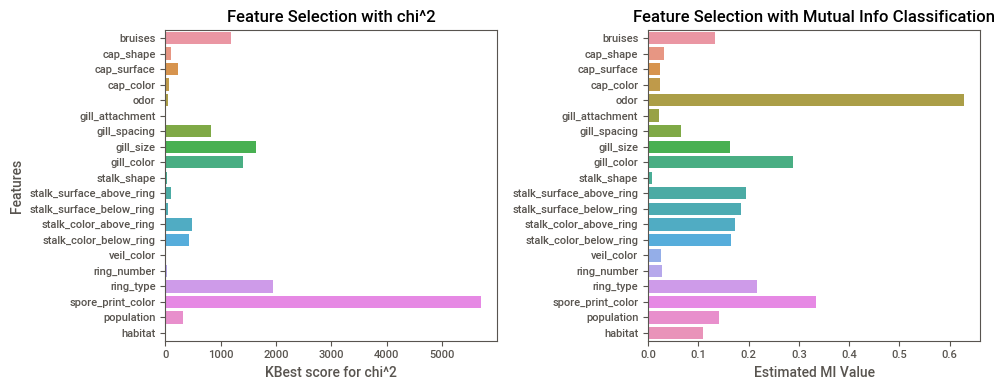

In [24]:
fig, axs = plt.subplots(1, 2, sharey=False, figsize=(10, 4))

feature_selectors = {
    0: [chi2, 'KBest score for chi^2', 'Feature Selection with chi^2'], 
    1: [mutual_info_classif, 'Estimated MI Value', 'Feature Selection with Mutual Info Classification']
}

for i in range(2):
    # Learn relationship from data
    f_sel = SelectKBest(score_func=feature_selectors[i][0], k='all').fit(encoded_X, y)
    # Transform input data
    X_fs = f_sel.transform(encoded_X)
    # Plot score for each feature
    sns.barplot(x=f_sel.scores_, y=list(encoded_X.columns), orient='h', ax=axs[i])
    axs[i].set_xlabel(feature_selectors[i][1])
    axs[i].set_title(feature_selectors[i][2])

axs[0].set_ylabel('Features')
plt.tight_layout()
plt.show()

Notable observations from above:

- `odor` outputted the highest MI value which coincides with the correlation found with target variable in the EDA. This seems to be one of the most important predictors.
- `spore_print_color`, `bruises`, `gill_spacing`, `gill_size`, `gill_color`, `ring_type` all display impressive scores from both scoring functions.
- `gill_attachment` scored low in both functions. This was also found in the EDA to be highly correlated with few other features, meaning it is a good candidate to drop from the feature set.

**Select the final features for model construction:**

In [25]:
encoded_X = encoded_X[[
    'bruises', 'cap_shape', 'cap_surface', 'cap_color', 'odor',  
    'gill_spacing', 'gill_size', 'gill_color', 'stalk_shape', 'stalk_surface_above_ring', 
    'stalk_surface_below_ring', 'stalk_color_above_ring', 'stalk_color_below_ring', 
    'veil_color', 'ring_number', 'ring_type', 'spore_print_color', 'population', 'habitat']]

### Model Construction: Classification
---------

**Define a set of classification models to employ and create table to track performance:**

In [26]:
# Define set of baseline models to iterate through
models = [
    LogisticRegression(),
    DecisionTreeClassifier(random_state=0),
    RandomForestClassifier(random_state=0),
    SVC(random_state=0),
    KNeighborsClassifier(n_neighbors=5)
]

# Instantiate a tabular structure to store results from each model
table = PrettyTable()
table.field_names = ['Model', 'Data', 'Accuracy', 'Precision', 'Recall', 'F1', 'ROC-AUC']

A variety of classification estimators were chosen to model the mushroom data, ranging from logistic-regression to support vector to tree-based methods. 

`LogisticRegression` is a modified version of linear regression that uses a sigmoid function to account for the discrete categorical outcome variables. On the other hand, tree-based classifiers rely on a single tree (`DecisionTreeClassifier`) or an ensemble of trees (`RandomForestClassifier`) constructed from a set of binary splits of branches based on the satisfaction of attribute conditions that aim to reduce entropy (or improve information gain) with each split. A random forest algorithm aims that builds many random trees in parallel is especially known for its predictive capabilities but tree-based methods have a knack for overfitting data. 

In a Support Vector classifier (`SVC`), the algorithm aims to find a hyperplane (in the context, it would be a plane in the 20+-dimensional space) based on the "support vectors", or the data points closest to this plane. This essentially serves as a decision boundary that would be used to distinguish the binary categorical target variable. As this algorithm is known to suit smaller datasets and for being robust to outliers, its performance in this scenario with a mid-sized dataset and high dimensionality will be interesting to observe.

`KNeighborsClassifier` relies on the neighbors of a data point as the best classifier for a record. This is known as a "lazy learner" as the model itself isn't constructed till a prediction needs to be made. At this point, a distance metric is used to track each other point to the record that needs to be classified. The specified hyperparameter number of nearest neighbors are then selected to figure out how to best classify the data point of interest. In a classification scenario such as this, ties are broken usually through a random selection between most occuring target classes.

Exploring these diverse methods, and assessing the models based on relevant metrics can help further narrow down the suitable method that best represents this dataset.

**Fit and evaluate each model based on various regression metrics:**

In [27]:
def fit_model(model, x_data, df_name):
    model = model.fit(x_data, y)
    pred = model.predict(x_data)
    acc = round(accuracy_score(y, pred), 2)
    precision = round(precision_score(y, pred), 2)
    recall = round(np.sqrt(recall_score(y, pred)), 2)
    f1 = round(f1_score(y, pred), 2) 
    roc_auc = round(roc_auc_score(y, pred),2)
    table.add_row([model, df_name, acc, precision, recall, f1, roc_auc])
    return [model, df_name, acc, precision, recall, f1, roc_auc]

results = []
fitted_models = []
for model in models:
    model_result = fit_model(model, encoded_X, 'encoded_X')
    results.append(model_result)
    fitted_models.append(model_result[0])  # store fitted models to reduce run time down pipeline

table

+----------------------------------------+-----------+----------+-----------+--------+------+---------+
|                 Model                  |    Data   | Accuracy | Precision | Recall |  F1  | ROC-AUC |
+----------------------------------------+-----------+----------+-----------+--------+------+---------+
|          LogisticRegression()          | encoded_X |   0.93   |    0.95   |  0.96  | 0.93 |   0.93  |
| DecisionTreeClassifier(random_state=0) | encoded_X |   1.0    |    1.0    |  1.0   | 1.0  |   1.0   |
| RandomForestClassifier(random_state=0) | encoded_X |   1.0    |    1.0    |  1.0   | 1.0  |   1.0   |
|          SVC(random_state=0)           | encoded_X |   1.0    |    1.0    |  1.0   | 1.0  |   1.0   |
|         KNeighborsClassifier()         | encoded_X |   1.0    |    1.0    |  1.0   | 1.0  |   1.0   |
+----------------------------------------+-----------+----------+-----------+--------+------+---------+

The releveant metrics chosen to evaluate the diverse set of classification models are: accuracy, precision, recall, f1, auc of roc curve. Outlined below is a high-level overview on how to interpret these metrics and the context in which they are used, followed by a discussion of the results above: 

`Accuracy`: Accuracy of classification predictions based on actual values is the standard metric, especially in the case of a fairly even proportion of classes in the target variable. Since the dataset contains a fairly equal amount of edible and poisonous varieties, this metric can be used to fairly gauge models against each other. Regardless, there are other metrics that might be even more suitable in the context of this study as described in the next sections. 

`Precision`: Precision/specificity is the proportion of correct *positive* predictions to the total *positive* predictions.

`Recall`: Recall/sensitivity is the proportion of correct *positive* predictions to the total number of positive records.

`F1`: The F1 score is the harmonic mean (therefore, penalizes extreme values) of precision and recall.

`Area under ROC Curve`: This value indicates how well the probabilities form the class-1 (poisonous varities) are separated from class-0 (edible varities). 

   Overall accuracy to evaluate a model makes sense when all classes (true positives, true negatives, false positives, false negatives) are equally important. However, if the costs of incorrect *positive* prediction is high, Precision is the better metric to use. If the costs of incorrect *negative* prediction is high, Recall is the better metric to use. With data such as this, it is very important for the model to show impressive predictive power for class-1 values (poisonous), as the cost of inaccuracies here are steep. If both costs are high, F1 is the best metric of choice to evaluate the model. So if we want to accurately gauge what the edible mushrooms are (to have a bigger selection of mushrooms to choose from while making a delicious & pleasingly smelling stew), as well as prevent poisonous varities from entering the kitchen, F1 is the best metric to use for this analysis.

From the results table, almost all of the baseline classifiers performed extremely well among the various metrics used to evaluate the models. This indicates that the models are learning to classify well based on the input features. Although dummy-vectorization of most of the features would be the more appropriate practice at this point, the performance of the baseline models indicates this may not be necessary for the models to parse through the relationships between features to accurately distinguish the target classes. Despite preventing the higher dimensionality, the models were trained on a substantial set of features of begin with, and could be over-fitting as well (especially the tree-based methods). Therefore, the best possible scoring here doesn't necessarily translate to the model generalizing to new data. Therefore it is important to note that these scores were generated from a "baseline" version of each model and therefore, this study is meant for a preliminary exploration to identify the patterns in this data. 

It is also noteworthy that the SVC & KNN performs fairly well (in terms of the metrics, and time complexity) for this rather larger sized dataset. As most of the models also display impressive F1 scores, almost any of the baseline models can be chosen for a deeper dive. 

### Analysis & Visualizations
-----------

**Visualize scoring metric results for each model:**

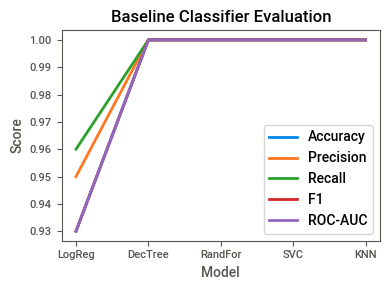

In [28]:
# Make dataframe for easier data manipulation and visualization
results_df = pd.DataFrame(results, columns=['Model', 'Data', 'Accuracy', 'Precision', 'Recall', 'F1', 'ROC-AUC'])
results_df['Model'] = ['LogReg', 'DecTree', 'RandFor', 'SVC', 'KNN']

fig, ax = plt.subplots(1, 1, figsize=(4, 3))

for metric in ['Accuracy', 'Precision', 'Recall', 'F1', 'ROC-AUC']:
    ax.plot(results_df.Model, results_df[metric], linewidth=2)

ax.set_title('Baseline Classifier Evaluation')
ax.set_xlabel('Model')
ax.set_ylabel('Score')
ax.legend(['Accuracy', 'Precision', 'Recall', 'F1', 'ROC-AUC'])

plt.tight_layout()
plt.show()

The line plot above serves as a simple visual alternative to the metrics chart, showing that apart from logistic regression, all the baseline models scored impressively among the important classification metrics.

In [29]:
@interact
def generate_report(model=fitted_models):
    """Generates desired report for specified model."""
    
    conf_mat = ConfusionMatrixDisplay.from_estimator(model, encoded_X, y)
    clf_rep =  print(classification_report(model.predict(encoded_X), y))
    roc_auc = RocCurveDisplay.from_estimator(model, encoded_X, y)
    
    return conf_mat, clf_rep, roc_auc

interactive(children=(Dropdown(description='model', options=(LogisticRegression(), DecisionTreeClassifier(rand…

## Explore best performing model in detail:

(Since almost all the baseline models performed well, RandomForestClassifier() was chosen for tuning for its predictive reputation and since it can scale well to even larger datasets.)

In [30]:
param_grid = {
    'n_estimators': range(10, 31, 10),
    'max_depth': range(3, 8)
}

gs_rf = GridSearchCV(estimator=RandomForestClassifier(random_state=0), param_grid=param_grid, scoring='f1', cv=10)
gs_rf.fit(encoded_X, y)
optimized_model = gs_rf.best_estimator_
optimized_model

RandomForestClassifier(max_depth=7, n_estimators=20, random_state=0)

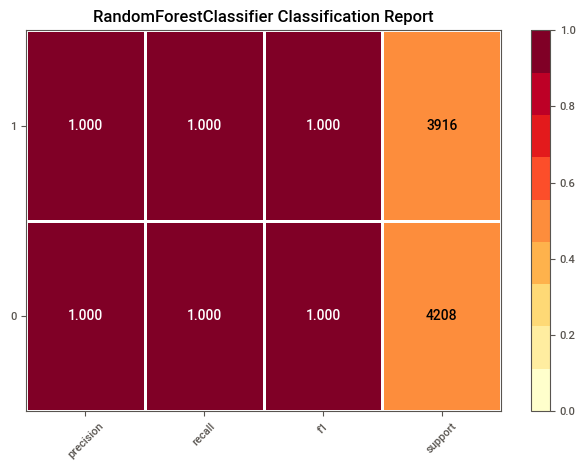

In [31]:
clf_rep = ClassificationReport(optimized_model, classes=list(set(y.values)), support=True)
clf_rep.fit(encoded_X, y).score(encoded_X, y)
clf_rep.finalize()

In [32]:
def generate_clf_rep(model):
    clf_rep = ClassificationReport(model, classes=['edible', 'poisonous'], support=True)
    clf_rep.fit(encoded_X, y).score(encoded_X, y)
    clf_rep.finalize()
    
def generate_conf_mat(model):
    conf_mat = ConfusionMatrix(model, classes=['edible', 'poisonous'])
    conf_mat.fit(encoded_X, y).score(encoded_X, y)
    conf_mat.finalize()   
    
def cls_pred_err(model):
    cpe = ClassPredictionError(model, classes=['edible', 'poisonous'])
    cpe.fit(encoded_X, y).score(encoded_X, y)
    cpe.finalize()   
    
def generate_roc(model):
    roc = ROCAUC(model, classes=['edible', 'poisonous'])
    roc.fit(encoded_X, y.astype('int')).score(encoded_X, y.astype('int'))
    roc.finalize()   

def generate_pr_curve(model):
    pr = PrecisionRecallCurve(model, classes=['edible', 'poisonous'], per_class=False)
    pr.fit(encoded_X, y.astype('int')).score(encoded_X, y.astype('int'))
    pr.finalize() 

## OUTPUT ANY VISUAL HERE FOR MODEL OF INTEREST; AS EACH SCORE IS 1.0, THESE PLOTS AREN'T VERY INTERESTING AND THEREFORE NOT OUTPUTTED BY DEFAULT

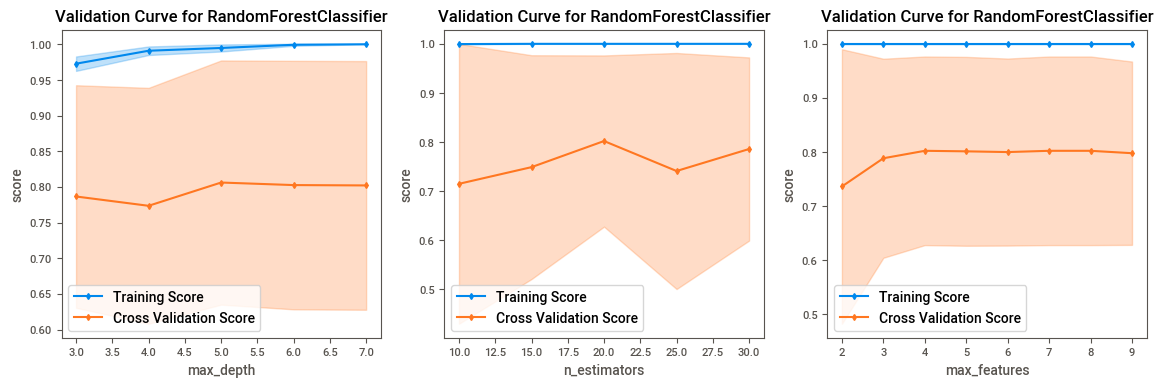

In [33]:
fig, axs = plt.subplots(1, 3, figsize=(14, 4))

# viz = LearningCurve(optimized_model, scoring='f1', cv=5, ax=axs[0]).fit(encoded_X, y).finalize()
viz = ValidationCurve(optimized_model, param_name='max_depth', param_range=range(3, 8), ax=axs[0]).fit(encoded_X, y).finalize()
viz = ValidationCurve(optimized_model, param_name='n_estimators', param_range=range(10, 31, 5), ax=axs[1]).fit(encoded_X, y).finalize()
viz = ValidationCurve(optimized_model, param_name='max_features', param_range=range(2, 10), ax=axs[2]).fit(encoded_X, y).finalize()

From above, we see that although the training predictions based on these models are extremely promising in their ability to perfectly distinguish edible mushrooms from poisonous ones, the F1 score takes a hit during cross-validation tests. Unfortunately, these scores do not seem to improve for various tuning of the hyperparameters at each section. After attempting this for some of the other models, Random Forest still displayed the best F1 score through these tests. Nonetheless, caution must be taken with these models as despite the fact that they are able to learn from the dataset well. One option here to further improve the model is to pursue aggressive feature-selection & dimensionality reduction techniques to prevent overfitting of the model and re-evaluate if the baseline versions for the reduced dataset will perform similarly, and if the resulting optimized model will generalize better with cross-validation implementation.

Next, we will examine the feature importances given through the optimized model. 

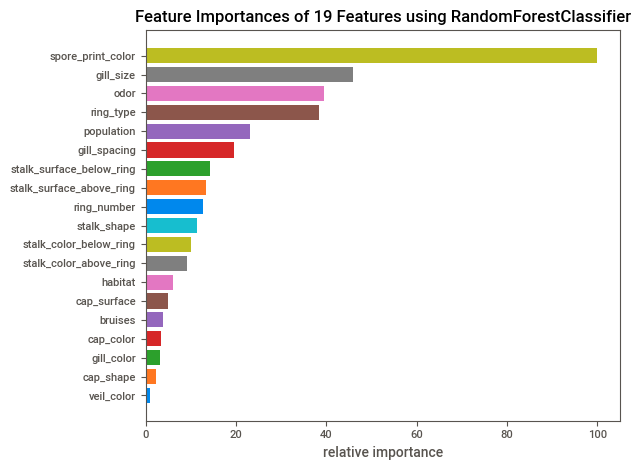

In [34]:
viz = FeatureImportances(optimized_model).fit(encoded_X, y).finalize()

`spore_print_color` has the highest relative importance score from the optimized model, which matches up extremely well from the mutual info exploration in the feature selection stage. Similarly, `gill_size`, `odor`, `ring_type` also were important for the model. As noted from the previous analysis, an aggressive approach to feature selection, using these results to tune the model further could be pursued to examine performance afterwards. 

### Conclusion
------

From our results, we see that a diverse set of classification models performed consistently well for this dataset. Despite the fact that the dataset has a fairly high dimensionality and a substantial amount of records, even classifiers such as KNN & SVC, which are commonly suited for smaller datasets, scored well among each of the classification metrics. It was important to consider F1 score over other metrics due to the fact that our use-case wanted to accomplish two things: maximize the possible selection of edible mushrooms to choose from (so that visually appealing & pleasingly smelling varieties can be used in a stew), but also minimize (in fact, eliminate) the possibility of electing for any poisonous varities. Since both class-0 and class-1 predictions were important, F1 was the best metric to evaluate our models and the baseline classifiers all did well in this regard. However, there are still potential concerns of the models generalizing to new mushroom data as even the optimized model seems to score a bit less than desired during cross-validation. In a future implementation, this can be addressed through several ways. This includes properly dummy-vectorizing the nominal variables and then implement a dimension-reductionality technique such as PCA before modeling. As the scope of this study was limited to exploring just the relationship of mushroom attributes for edible & poisonous varities, which involved constructing and comparing many models / examining the original features, it made more sense to prevent dimensionality expansion & retaining original attibute information. But a study that builds on this would take these into account to hopefully yield a model that we can be more confident in. Keeping the original dimensions allow us to closely examine which mushroom attributes contribute the most to accurately distinguishing between the edible & poisonous varities. From this, we find that spore print color is very important, along with gill size, odor, and ring type. As the end-goal is to develop an appealing & safe mushroom stew, these attributes (which contains odor) along with other color attributes can be selected for modeling to yield the best classifier, as well as, have the necessary data to make menu decisions. 

Below consists of the same jitter plots from the exploratory analysis, but setup for just the odor and color-related attributes that displayed high importance in the feature-importance plot, as a summarizing visual for our analysis:

In [35]:
imp_odor_and_col_attr = ['spore_print_color', 'odor', 'stalk_color_below_ring', 'stalk_color_above_ring']
imp_odor_and_col_attr2 = ['odor', 'spore_print_color', 'stalk_color_below_ring', 'stalk_color_above_ring']
color_options = ['blue', 'forestgreen', 'darkcyan', 'black']
mushroom_df['label'] = mushroom_df['is_poisonous'].map(lambda x: 'edible' if x == 0 else 'poisonous')  # original labels for plot

@interact
def plot_jitter(x_var=imp_odor_and_col_attr, y_var=imp_odor_and_col_attr2, hue='label', edible_col=color_options):
    """Outputs ggplot figure with custom plot specs and random feature pair."""
    
    # Set figure specifications for each attribute pair
    chart = ggplot(data=mushroom_df, mapping=aes(x=x_var, y=y_var, color=hue))
    points = geom_jitter(alpha = 0.4)  
    labels = labs(x=x_var, y=y_var)
    theme_grammer = theme(figure_size=(8, 6))  
    colors = scale_color_manual(values=[edible_col, 'red'])
    
    fig = chart + points + labels + theme_bw() + theme_grammer + colors
    return fig

interactive(children=(Dropdown(description='x_var', options=('spore_print_color', 'odor', 'stalk_color_below_r…

## Decision Guide

**This guide is designed to navigate somebody through a set of decisions that eventually leads to only edible options. To make the most intuitive guide, the starting point for making these decisions begins with where the person encounters the mushroom ('habitat').**

---

In [36]:
def plot_jitter(df, x_var, y_var):
    """Outputs ggplot figure with custom plot specs and chosen feature pair."""
    
    # Set figure specifications for each attribute pair
    chart = ggplot(data=df, mapping=aes(x=x_var, y=y_var, color='label'))
    points = geom_jitter(alpha = 0.4)  
    labels = labs(x=x_var, y=y_var)
    theme_grammer = theme(figure_size=(8, 6))  
    colors = scale_color_manual(values=['blue', 'red'])
    
    fig = chart + points + labels + theme_bw() + theme_grammer + colors
    return fig

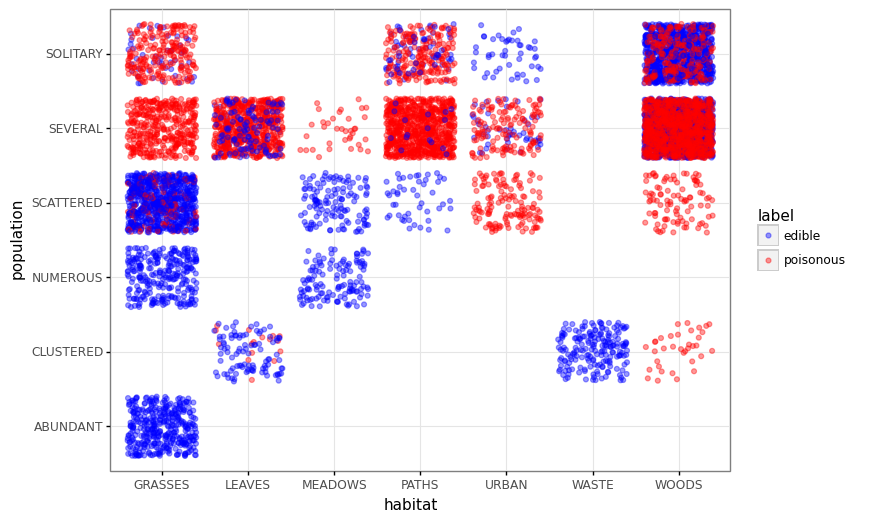

<ggplot: (344916140)>

In [37]:
plot_jitter(mushroom_df, 'habitat', 'population')

Based on above, the rules to follow to eliminate poisonous varities (without eliminating any safe options):

- In 'GRASSES' & 'MEADOWS' habitats, avoid picking any several-bunched mushrooms.
- In 'URBAN' & 'WOODS' habitats, avoid picking any scattered or clustered mushrooms.

Below, those filters were implemented in our dataset before exploring the next stage of decision-making.

In [38]:
filtered_df = mushroom_df[~((mushroom_df.habitat == 'WOODS') & (mushroom_df.population == 'CLUSTERED'))]
filtered_df = filtered_df[~((filtered_df.habitat == 'WOODS') & (filtered_df.population == 'SCATTERED'))]
filtered_df = filtered_df[~((filtered_df.habitat == 'URBAN') & (filtered_df.population == 'SCATTERED'))]
filtered_df = filtered_df[~((filtered_df.habitat == 'GRASSES') & (filtered_df.population == 'SEVERAL'))]
filtered_df = filtered_df[~((filtered_df.habitat == 'MEADOWS') & (filtered_df.population == 'SEVERAL'))]

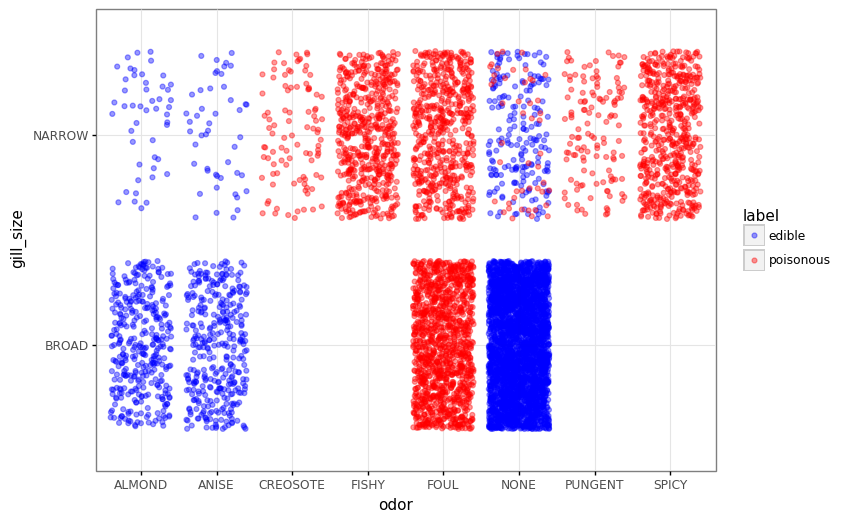

<ggplot: (344916080)>

In [39]:
plot_jitter(filtered_df, 'odor', 'gill_size')

Based on above, the rules to follow to eliminate some poisonous varities (without eliminating any safe options):

- Avoid any mushrooms with 'CREOSOTE' or 'FISHY' or 'FOUL' or 'SPICY', 'PUNGENT' odors.

Below, those filters were implemented in our dataset to explore the next stage of decision-making.

In [40]:
filtered_df = filtered_df[(filtered_df.odor == 'ALMOND') | (filtered_df.odor == 'ANISE') | (filtered_df.odor == 'NONE')]

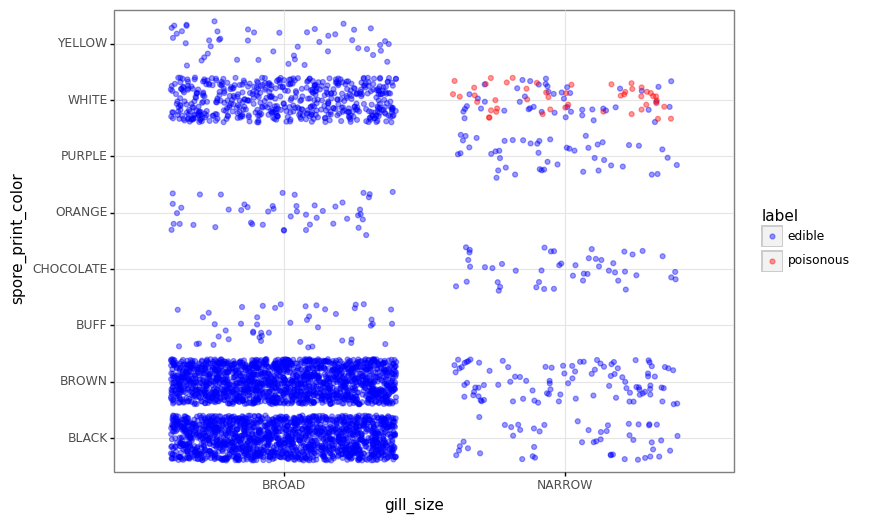

<ggplot: (346057376)>

In [41]:
plot_jitter(filtered_df, 'gill_size', 'spore_print_color')

Based on above, the rules to follow to eliminate ALL remaining poisonous varities (which eliminates few edible options but ends the decision-making process):

- Avoid any mushrooms with 'NARROW' gill size AND 'WHITE' spore print color. 

In [42]:
filtered_df = filtered_df[~((filtered_df.gill_size == 'NARROW') & (filtered_df.spore_print_color == 'WHITE'))]

In [43]:
filtered_df.label.value_counts()

edible       4160
poisonous       0
Name: label, dtype: int64

Although some edible mushroom options were also eliminated at the end, the decision guide maximizes precision of selecting safe mushrooms, while retaining as many choices possible for the chef to choose from while designing their menu. The walkthrough guide also eliminated the poor smelling options (which naturally leaves behind the better tasting varities) and therefore the primary choice the chef will have to make judgment on is the color of their preference. In the end, out plan eliminates ALL poisonous varities (maximizing precision), retains as many edible options as possible (to give the chef more choices), with the simplest guide (least amount of decisions) possible. 